# Bayesian Hierarchical / Multilevel Models (from scratch)

**Goal:** learn and implement a two-level Bayesian hierarchical model with a hand-rolled **Gibbs sampler**.
We’ll simulate grouped data, fit the model, check convergence, inspect “shrinkage,” and do posterior predictive checks.

**Model (two-level normal):**

* Data level: $y_{ij} \mid \theta_j, \sigma^2 \sim \mathcal{N}(\theta_j, \sigma^2)$
  (observation $i$ in group $j$)
* Group level: $\theta_j \mid \mu, \tau^2 \sim \mathcal{N}(\mu, \tau^2)$
* Hyperpriors:
  $\mu \sim \mathcal{N}(m_0, s_0^2),\quad \sigma^2 \sim \text{InvGamma}(a_\sigma,b_\sigma),\quad \tau^2 \sim \text{InvGamma}(a_\tau,b_\tau)$

Why this model?

* It **shares information across groups** (“partial pooling”).
* Estimates of group means $\theta_j$ **shrink toward** the overall mean $\mu$, improving stability especially for small groups.

We’ll derive the full conditionals (all conjugate) and sample:

* $\theta_j \mid \text{rest} \sim \mathcal{N}(\cdot,\cdot)$
* $\mu \mid \text{rest} \sim \mathcal{N}(\cdot,\cdot)$
* $\sigma^2 \mid \text{rest} \sim \text{InvGamma}(\cdot,\cdot)$
* $\tau^2 \mid \text{rest} \sim \text{InvGamma}(\cdot,\cdot)$

In [3]:
# Imports & basic utilities

import numpy as np
import math
import matplotlib.pyplot as plt

np.random.seed(42)  # for reproducibility

In [4]:
def invgamma_sample(shape: float, rate: float) -> float:
    """
    Draw a sample from the Inverse-Gamma(shape=a, rate=b) distribution.
    
    Parameterization used here:
        p(x) ∝ x^{-(a+1)} * exp(-b / x),  x > 0,  a>0, b>0
    
    Sampling trick:
        If X ~ InvGamma(a, b), then 1/X ~ Gamma(a, rate=b).
        NumPy's gamma uses shape k and *scale* θ; with rate=b, set θ = 1/b.
    """
    if shape <= 0 or rate <= 0:
        raise ValueError("shape and rate must be positive for inverse-gamma.")
    g = np.random.gamma(shape=shape, scale=1.0 / rate)
    return 1.0 / g

## Simulate hierarchical data

We create $J$ groups with $n_j$ observations each.
Generative story:

1. Draw a global mean $\mu_{\text{true}}$ (fixed in simulation).
2. For each group $j$, draw a latent mean $\theta_j \sim \mathcal{N}(\mu_{\text{true}}, \tau_{\text{true}}^2)$.
3. For each observation $i$ in group $j$, draw $y_{ij} \sim \mathcal{N}(\theta_j, \sigma_{\text{true}}^2)$.

We’ll keep $\mu_{\text{true}}, \tau_{\text{true}}, \sigma_{\text{true}}$ modest so patterns are clear.

In [5]:
def simulate_hierarchical_normal(J=10, n_min=5, n_max=30,
                                 mu_true=50.0, tau_true=10.0, sigma_true=5.0,
                                 seed: int = 123):
    """
    Simulate hierarchical normal data with varying group sizes.

    Args:
        J: number of groups.
        n_min, n_max: min/max group sizes (inclusive).
        mu_true: global mean.
        tau_true: SD of group means around mu_true.
        sigma_true: observation noise SD within each group.
        seed: RNG seed.

    Returns:
        y: list of length J; y[j] is np.array of observations for group j.
        n: np.array of group sizes (length J).
        theta_true: np.array of true group means (length J).
        params_true: dict with 'mu_true', 'tau_true', 'sigma_true'
    """
    rng = np.random.default_rng(seed)
    n = rng.integers(low=n_min, high=n_max + 1, size=J)
    theta_true = rng.normal(loc=mu_true, scale=tau_true, size=J)

    y = []
    for j in range(J):
        yj = rng.normal(loc=theta_true[j], scale=sigma_true, size=n[j])
        y.append(yj)

    params_true = dict(mu_true=mu_true, tau_true=tau_true, sigma_true=sigma_true)
    return y, n, theta_true, params_true

# Simulate
y, n, theta_true, params_true = simulate_hierarchical_normal(J=12, n_min=6, n_max=25,
                                                             mu_true=60.0, tau_true=8.0, sigma_true=6.0)
J = len(y)
N = sum(n)
print(f"Groups J={J}, total observations N={N}")

Groups J=12, total observations N=158


## Quick look at the data

We’ll compute the **group sample means** and **standard deviations** to see variability.
This will help visualize why partial pooling (shrinkage) is useful: small groups tend to have noisy means.


Overall mean: 61.11


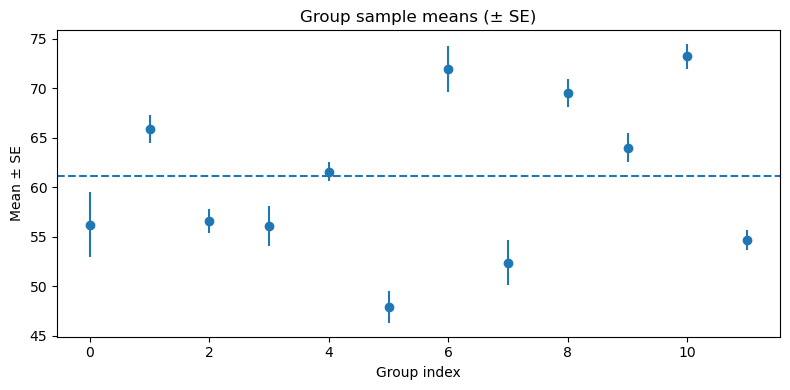

In [6]:
group_means = np.array([yi.mean() for yi in y])
group_sds   = np.array([yi.std(ddof=1) for yi in y])
group_ns    = np.array(n)

overall_mean = np.concatenate(y).mean()
print("Overall mean:", round(overall_mean, 2))

# Plot group means with 1 SD error bar (just exploratory)
plt.figure(figsize=(8, 4))
x = np.arange(J)
plt.errorbar(x, group_means, yerr=group_sds/np.sqrt(group_ns), fmt='o')
plt.axhline(overall_mean, linestyle='--')
plt.title("Group sample means (± SE)")
plt.xlabel("Group index")
plt.ylabel("Mean ± SE")
plt.tight_layout()
plt.show()

## Priors and intuition

We’ll use **weakly informative** priors:

* $\mu \sim \mathcal{N}(m_0, s_0^2)$ where $m_0$ is set near the overall sample mean; $s_0$ large.
* $\sigma^2 \sim \text{InvGamma}(a_\sigma, b_\sigma)$ with $a_\sigma, b_\sigma$ small (but valid), centering on plausible noise scales.
* $\tau^2 \sim \text{InvGamma}(a_\tau, b_\tau)$ likewise.

> Using very flat priors (e.g., huge variance) can slow convergence; weakly informative is a good default.

In [7]:
# Set weakly-informative priors
m0 = overall_mean      # center prior for mu at sample mean
s0 = 20.0              # prior SD for mu (quite wide)

a_sigma = 2.0
b_sigma = 2.0          # prior mean for sigma^2 is b/(a-1) = 2 / 1 = 2 (on the small side, but weak)
a_tau = 2.0
b_tau = 16.0           # prior mean for tau^2 is 16 (tau ~ 4), allows moderate between-group spread

print(f"mu prior: N({m0:.2f}, {s0**2:.2f})")
print(f"sigma^2 prior: InvGamma(a={a_sigma}, b={b_sigma})")
print(f"tau^2 prior:   InvGamma(a={a_tau}, b={b_tau})")


mu prior: N(61.11, 400.00)
sigma^2 prior: InvGamma(a=2.0, b=2.0)
tau^2 prior:   InvGamma(a=2.0, b=16.0)


## Deriving the Gibbs updates (simple language)

Because everything is **Gaussian** (with inverse-gamma for variances), the conditionals are conjugate and easy to sample:

* **Update $\theta_j$**: it balances the **group sample mean** and the **current global mean $\mu$**.

  $$
  \theta_j \mid \cdot \sim \mathcal{N}\Big(\ \underbrace{V_j\big(\tfrac{n_j \bar{y}_j}{\sigma^2} + \tfrac{\mu}{\tau^2}\big)}_{\text{weighted average}},\ \underbrace{V_j}_{\text{variance}}\ \Big),
  \quad V_j = \left(\tfrac{n_j}{\sigma^2} + \tfrac{1}{\tau^2}\right)^{-1}
  $$
* **Update $\mu$**: average of the $\theta_j$’s with prior pull to $m_0$.

  $$
  \mu \mid \cdot \sim \mathcal{N}\Big(\ V_\mu\big(\tfrac{\sum_j \theta_j}{\tau^2} + \tfrac{m_0}{s_0^2}\big),\ V_\mu\Big),\ 
  V_\mu = \left(\tfrac{J}{\tau^2} + \tfrac{1}{s_0^2}\right)^{-1}
  $$
* **Update $\sigma^2$**: inverse-gamma with residual sum of squares.

  $$
  \sigma^2 \mid \cdot \sim \text{InvGamma}\Big(a_\sigma + \tfrac{N}{2},\ b_\sigma + \tfrac{1}{2}\sum_{j,i}(y_{ij}-\theta_j)^2\Big)
  $$
* **Update $\tau^2$**: inverse-gamma with between-group variation.

  $$
  \tau^2 \mid \cdot \sim \text{InvGamma}\Big(a_\tau + \tfrac{J}{2},\ b_\tau + \tfrac{1}{2}\sum_j(\theta_j-\mu)^2\Big)
  $$

We’ll implement these four updates in a loop.


In [8]:
def gibbs_hier_normal(y, n, m0, s0, a_sigma, b_sigma, a_tau, b_tau,
                      n_iters=8000, burn_in=2000, thin=5, seed: int = 2024):
    """
    Gibbs sampler for the hierarchical normal model:
        y_ij | theta_j, sigma^2 ~ N(theta_j, sigma^2)
        theta_j | mu, tau^2 ~ N(mu, tau^2)
        mu ~ N(m0, s0^2)
        sigma^2 ~ InvGamma(a_sigma, b_sigma)
        tau^2 ~ InvGamma(a_tau, b_tau)

    Args:
        y: list of 1D np.arrays, y[j] are observations for group j
        n: 1D np.array of group sizes
        m0, s0: prior mean and SD for mu
        a_sigma, b_sigma: InvGamma prior params for sigma^2
        a_tau, b_tau: InvGamma prior params for tau^2
        n_iters: total MCMC iterations
        burn_in: number of initial draws to discard
        thin: keep every 'thin'-th sample
        seed: RNG seed

    Returns:
        samples: dict with draws for 'mu', 'sigma2', 'tau2', 'theta' (shape [S, J])
                 where S is number of kept samples.
    """
    rng = np.random.default_rng(seed)
    J = len(y)
    N = int(sum(n))
    ybar = np.array([yi.mean() for yi in y])  # sufficient statistic per group

    # Initialize parameters
    mu = float(np.mean(ybar))
    sigma2 = float(np.var(np.concatenate(y), ddof=1))
    tau2 = float(np.var(ybar, ddof=1) + 1e-6)
    theta = ybar.copy()

    kept = []
    for t in range(n_iters):
        # --- Update theta_j (conditionally normal)
        for j in range(J):
            prec = (n[j] / sigma2) + (1.0 / tau2)
            Vj = 1.0 / prec
            mj = Vj * ((n[j] * ybar[j]) / sigma2 + (mu / tau2))
            theta[j] = rng.normal(loc=mj, scale=math.sqrt(Vj))

        # --- Update mu (conditionally normal)
        prec_mu = (J / tau2) + (1.0 / (s0**2))
        V_mu = 1.0 / prec_mu
        m_mu = V_mu * ((theta.sum() / tau2) + (m0 / (s0**2)))
        mu = rng.normal(loc=m_mu, scale=math.sqrt(V_mu))

        # --- Update sigma^2 (Inv-Gamma)
        rss = 0.0
        for j in range(J):
            rss += np.sum((y[j] - theta[j])**2)
        a_post = a_sigma + 0.5 * N
        b_post = b_sigma + 0.5 * rss
        sigma2 = invgamma_sample(shape=a_post, rate=b_post)

        # --- Update tau^2 (Inv-Gamma)
        ssb = np.sum((theta - mu)**2)
        a_post_tau = a_tau + 0.5 * J
        b_post_tau = b_tau + 0.5 * ssb
        tau2 = invgamma_sample(shape=a_post_tau, rate=b_post_tau)

        # Store (with thinning)
        if t >= burn_in and ((t - burn_in) % thin == 0):
            kept.append((mu, sigma2, tau2, theta.copy()))

    kept = np.array(kept, dtype=object)
    S = kept.shape[0]
    mus = np.array([k[0] for k in kept])
    sigmas2 = np.array([k[1] for k in kept])
    taus2 = np.array([k[2] for k in kept])
    thetas = np.stack([k[3] for k in kept], axis=0)  # shape [S, J]

    return dict(mu=mus, sigma2=sigmas2, tau2=taus2, theta=thetas)


## Run the sampler

We’ll run for a few thousand iterations, discard burn-in, and thin mildly to reduce autocorrelation.
(For production, you’d tune these; here we aim for clarity + speed.)

In [9]:
samples = gibbs_hier_normal(
    y=y, n=n,
    m0=m0, s0=s0,
    a_sigma=a_sigma, b_sigma=b_sigma,
    a_tau=a_tau, b_tau=b_tau,
    n_iters=12000, burn_in=3000, thin=10, seed=99
)

S = len(samples['mu'])
print(f"Kept posterior draws: S={S}")


Kept posterior draws: S=900


## Posterior summaries

We compute posterior means and 95% credible intervals for:

* Global mean $\mu$
* Variances $\sigma^2$ (within) and $\tau^2$ (between)
* Group means $\theta_j$

In [10]:
def summary_1d(name, arr):
    mean = np.mean(arr)
    lo, hi = np.quantile(arr, [0.025, 0.975])
    print(f"{name:10s} | mean = {mean:8.3f} | 95% CI = [{lo:8.3f}, {hi:8.3f}]")

summary_1d("mu", samples['mu'])
summary_1d("sigma^2", samples['sigma2'])
summary_1d("tau^2", samples['tau2'])

theta_mean = samples['theta'].mean(axis=0)
theta_lo   = np.quantile(samples['theta'], 0.025, axis=0)
theta_hi   = np.quantile(samples['theta'], 0.975, axis=0)

print("\nFirst few group thetas (posterior mean ± 95% CI):")
for j in range(min(6, J)):
    print(f"theta[{j:02d}] ≈ {theta_mean[j]:.2f}  [{theta_lo[j]:.2f}, {theta_hi[j]:.2f}]")


mu         | mean =   60.962 | 95% CI = [  56.465,   65.359]
sigma^2    | mean =   29.783 | 95% CI = [  23.652,   37.280]
tau^2      | mean =   53.568 | 95% CI = [  23.494,  107.176]

First few group thetas (posterior mean ± 95% CI):
theta[00] ≈ 56.66  [52.17, 60.75]
theta[01] ≈ 65.65  [63.26, 67.82]
theta[02] ≈ 56.75  [54.09, 59.23]
theta[03] ≈ 56.48  [52.50, 60.25]
theta[04] ≈ 61.59  [59.32, 63.70]
theta[05] ≈ 48.78  [45.42, 52.18]


## Convergence diagnostics (quick visual)

Trace plots are a simple, practical check.
We’ll plot traces for $\mu$, $\sigma^2$, $\tau^2$.
(For rigorous analysis, also check autocorrelation and run multiple chains.)


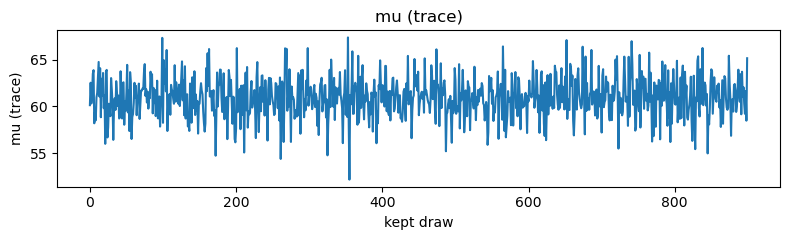

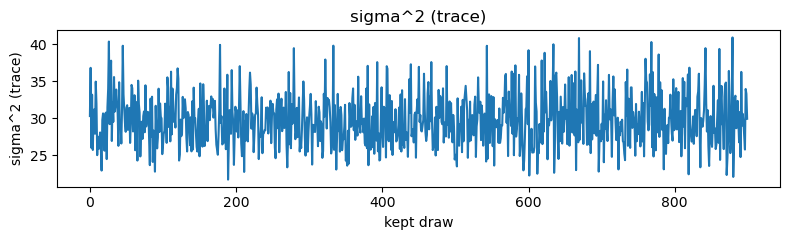

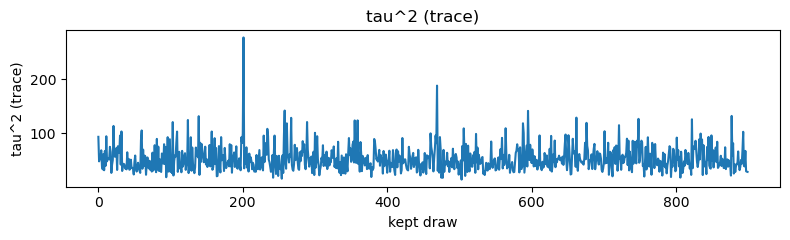

In [11]:
def trace_plot(arr, title):
    plt.figure(figsize=(8, 2.5))
    plt.plot(arr)
    plt.title(title)
    plt.xlabel("kept draw")
    plt.ylabel(title)
    plt.tight_layout()
    plt.show()

trace_plot(samples['mu'], "mu (trace)")
trace_plot(samples['sigma2'], "sigma^2 (trace)")
trace_plot(samples['tau2'], "tau^2 (trace)")


## Shrinkage: partial pooling in action

Compare:

* **Raw group means** (no pooling)
* **Posterior means of $\theta_j$** (partial pooling toward $\mu$)

Smaller groups should shrink **more** (they’re less certain).
This is a hallmark of hierarchical models.


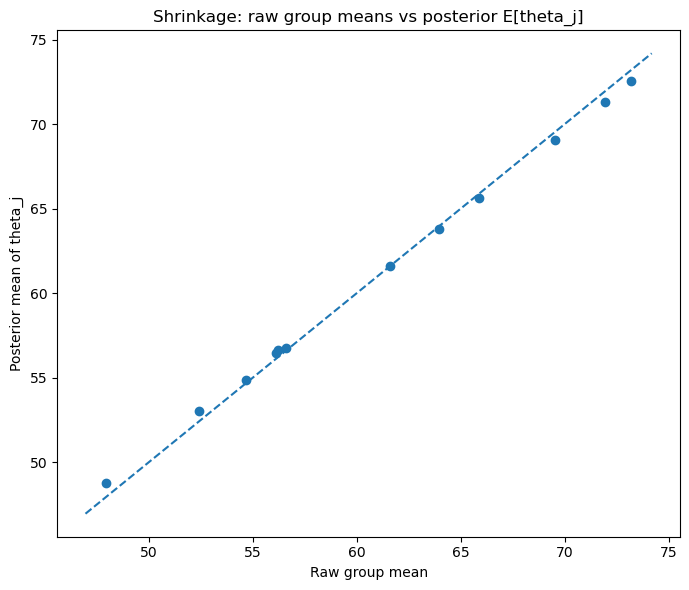

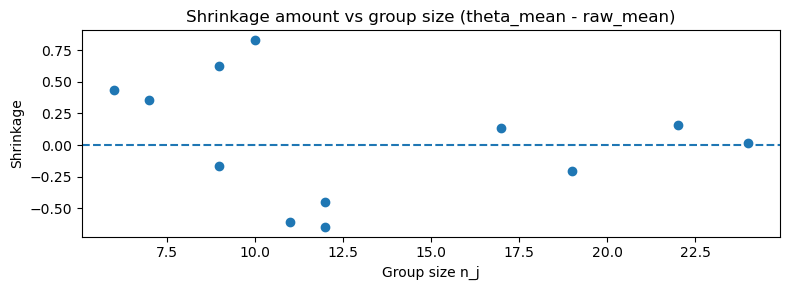

In [12]:
plt.figure(figsize=(7, 6))
plt.scatter(group_means, theta_mean)
plt.plot([group_means.min()-1, group_means.max()+1],
         [group_means.min()-1, group_means.max()+1],
         linestyle='--')
plt.title("Shrinkage: raw group means vs posterior E[theta_j]")
plt.xlabel("Raw group mean")
plt.ylabel("Posterior mean of theta_j")
plt.tight_layout()
plt.show()

# Optional: visualize shrinkage amount vs group size
shrinkage = theta_mean - group_means
plt.figure(figsize=(8, 3))
plt.scatter(group_ns, shrinkage)
plt.axhline(0.0, linestyle='--')
plt.title("Shrinkage amount vs group size (theta_mean - raw_mean)")
plt.xlabel("Group size n_j")
plt.ylabel("Shrinkage")
plt.tight_layout()
plt.show()

## Posterior predictive checks (PPC)

Two common PPCs:

1. **New observation within an existing group $j$**:
   Draw $y^\*\sim\mathcal{N}(\theta_j, \sigma^2)$ for each posterior draw.
2. **Observation from a new future group**:
   Draw $\theta^\* \sim \mathcal{N}(\mu,\tau^2)$, then $y^\*\sim\mathcal{N}(\theta^\*,\sigma^2)$.

We’ll do both and look at the predictive distributions.

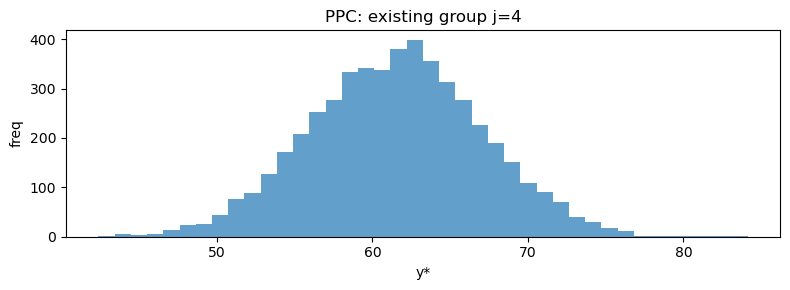

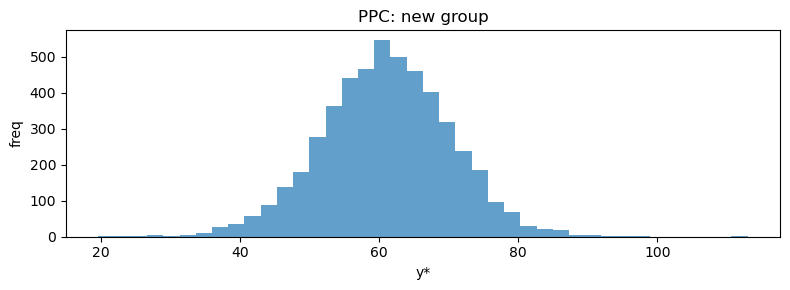

In [13]:
def posterior_predictive_existing_group(samples, j, size=2000, seed: int = 7):
    """
    Posterior predictive for a new observation in an *existing* group j.
    y* | theta_j, sigma^2 ~ Normal(theta_j, sigma^2)
    """
    rng = np.random.default_rng(seed)
    S = len(samples['mu'])
    idx = rng.choice(S, size=size, replace=True)
    theta_draws = samples['theta'][idx, j]
    sigma2_draws = samples['sigma2'][idx]
    y_pred = rng.normal(loc=theta_draws, scale=np.sqrt(sigma2_draws))
    return y_pred

def posterior_predictive_new_group(samples, size=2000, seed: int = 8):
    """
    Posterior predictive for a new observation from a *new* group.
    theta* ~ Normal(mu, tau^2), then y* ~ Normal(theta*, sigma^2)
    """
    rng = np.random.default_rng(seed)
    S = len(samples['mu'])
    idx = rng.choice(S, size=size, replace=True)
    mu_draws = samples['mu'][idx]
    tau2_draws = samples['tau2'][idx]
    sigma2_draws = samples['sigma2'][idx]
    theta_star = rng.normal(loc=mu_draws, scale=np.sqrt(tau2_draws))
    y_pred = rng.normal(loc=theta_star, scale=np.sqrt(sigma2_draws))
    return y_pred

# Example PPC:
j_example = int(np.argmax(group_ns))  # largest group index
y_pred_exist = posterior_predictive_existing_group(samples, j=j_example, size=5000)
y_pred_new   = posterior_predictive_new_group(samples, size=5000)

plt.figure(figsize=(8, 3))
plt.hist(y_pred_exist, bins=40, alpha=0.7)
plt.title(f"PPC: existing group j={j_example}")
plt.xlabel("y*")
plt.ylabel("freq")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.hist(y_pred_new, bins=40, alpha=0.7)
plt.title("PPC: new group")
plt.xlabel("y*")
plt.ylabel("freq")
plt.tight_layout()
plt.show()


## Benchmarks: pooled vs unpooled vs hierarchical

* **Unpooled**: use each group’s raw mean (high variance for small $n_j$).
* **Pooled**: ignore groups; use overall mean (biased if groups differ).
* **Hierarchical**: compromise via partial pooling.

Because we know the **true** $\theta_j$ from simulation, we can compare **RMSE** of estimates.


In [14]:
# Estimators
pooled_estimate = np.full(J, overall_mean)
unpooled_estimate = group_means
hier_estimate = theta_mean

def rmse(est, truth): 
    return float(np.sqrt(np.mean((est - truth)**2)))

rmse_pooled   = rmse(pooled_estimate,   theta_true)
rmse_unpooled = rmse(unpooled_estimate, theta_true)
rmse_hier     = rmse(hier_estimate,     theta_true)

print(f"RMSE (pooled)     : {rmse_pooled:.3f}")
print(f"RMSE (unpooled)   : {rmse_unpooled:.3f}")
print(f"RMSE (hierarchical): {rmse_hier:.3f}")


RMSE (pooled)     : 6.945
RMSE (unpooled)   : 1.563
RMSE (hierarchical): 1.361


## What you learned (simple recap)

* **Hierarchical models** combine information across groups while respecting group differences.
* **Gibbs sampling** for this model is straightforward due to conjugacy: each conditional is normal or inverse-gamma.
* **Shrinkage** happens naturally: noisy group means are pulled toward the overall mean more strongly.
* **Posterior predictive checks** help validate the model’s realism and quantify uncertainty for new or existing groups.


## (Optional) Fitting the same model with PyMC

If you want to **validate** your from-scratch sampler or scale to more complex models (e.g., non-Gaussian outcomes, random slopes), use **PyMC**. Here’s a minimal template (commented out).

> You can uncomment and run if `pymc` is available in your environment.


In [15]:
# %% Optional PyMC check (uncomment if pymc is installed)
# import pymc as pm
# import aesara.tensor as at
#
# with pm.Model() as mdl:
#     mu = pm.Normal("mu", mu=m0, sigma=s0)
#     tau2 = pm.InverseGamma("tau2", alpha=a_tau, beta=b_tau)
#     sigma2 = pm.InverseGamma("sigma2", alpha=a_sigma, beta=b_sigma)
#     tau = pm.Deterministic("tau", at.sqrt(tau2))
#     sigma = pm.Deterministic("sigma", at.sqrt(sigma2))
#
#     theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J)
#
#     # Likelihood: stack all groups
#     y_obs = []
#     for j in range(J):
#         y_obs.append(pm.Normal(f"y_{j}", mu=theta[j], sigma=sigma, observed=y[j]))
#
#     idata = pm.sample(draws=2000, tune=1000, target_accept=0.9, chains=2, random_seed=7)
#
# pm.summary(idata, var_names=["mu", "sigma", "tau", "theta"])